In [ ]:

import time
import math
import random
import tensorflow as tf
from functools import reduce
from operator import mul

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
sys.path.append('/Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/dataset.py')
import dataset
import cv2
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Input, Lambda, Dense, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

In [13]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['AiArt', 'RealArt']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

paths = '/Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA'
checkpoint_dir = "models/"

In [14]:
data = dataset.Train_Data_Loader(paths, img_size, classes)
test_images, test_ids = dataset.Test_Data_Loader(paths, img_size, classes)

Reading images from /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA
Loading AiArt files (Index: 0)
Found 499 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/AiArt
Loading RealArt files (Index: 1)
Found 412 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/RealArt


libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


Reading images from /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA
Loading AiArt files (Index: 0)
Found 499 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/AiArt
Loading RealArt files (Index: 1)
Found 412 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/RealArt


libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


In [15]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		582
- Test-set:		183
- Validation-set:	146


In [16]:

def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    plt.show()

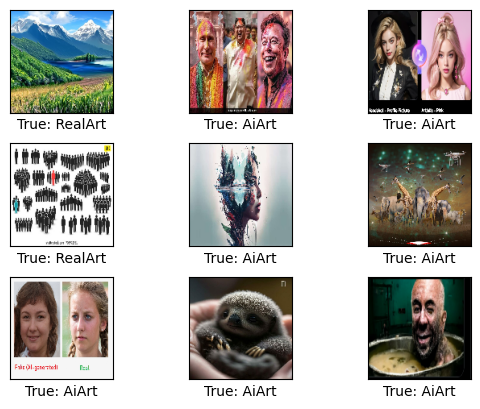

In [17]:
# Get some random images and their labels from the train set.
images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [47]:
# Helper Functions for Tensorflow

def new_weights(shape):
    return tf.Variable(tf.random.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    # Create the convolutional layer using Keras Conv2D
    conv_layer = Conv2D(filters=num_filters,
                       kernel_size=filter_size,
                       strides=(1, 1),
                       padding='same',
                       activation=None,
                       kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                       bias_initializer=tf.constant_initializer(0.05))
    
    layer = conv_layer(input)
    
    # Use pooling to down-sample the image resolution
    if use_pooling:
        layer = MaxPooling2D(pool_size=(2, 2), 
                            strides=(2, 2), 
                            padding='same')(layer)
    
    # Rectified Linear Unit (ReLU)
    layer = ReLU()(layer)
    
    return layer, conv_layer.kernel

def flatten_layer(layer):
    # Get the static shape (for symbolic tensors like KerasTensor)
    layer_shape = layer.shape
    
    # Extract dimensions (height, width, channels), excluding batch size
    dim_slice = layer_shape[1:4]  # Static shape slice (e.g., (height, width, channels))
    
    # Calculate number of features for symbolic shape
    # Handle None in shape by treating it as symbolic
    num_features = 1
    for dim in dim_slice:
        if dim is not None:
            num_features *= dim
        else:
            raise ValueError("Dynamic dimensions detected in layer shape. Ensure all dimensions (except batch) are known.")
    
    # Use Keras Flatten layer for symbolic tensors
    layer_flat = tf.keras.layers.Flatten()(layer)
    
    return layer_flat, num_features

def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    # Create a Dense layer
    layer = tf.keras.layers.Dense(
        units=num_outputs,
        use_bias=True,
        kernel_initializer='glorot_uniform',  # Default Keras initializer
        bias_initializer='zeros'            # Default Keras initializer
    )(input)
    
    # Apply ReLU activation if specified
    if use_relu:
        layer = tf.keras.layers.ReLU()(layer)
    
    return layer

In [43]:
# Place Holder Variable
x = Input(shape=(img_size_flat,), name='x', dtype=tf.float32)  # Shape: [batch_size, 49152]
x_image = Input(shape=(img_size, img_size, num_channels), name='x_input', dtype=tf.float32)  # Shape: [batch_size, 128, 128, 3]
y_true = Input(shape=(num_classes,), name='y_true', dtype=tf.float32)  # Shape: [batch_size, 2]

# Use Lambda layer to wrap the tf.argmax operation
y_true_cls = Lambda(lambda x: tf.argmax(x, axis=1), name='y_true_cls')(y_true)  # Shape: [batch_size]

In [32]:
# Convolutional Layers

# layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

# layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

# layer 3
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [48]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [52]:
# Fully-connected Layers
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [60]:
# normalising  perdicted values
y_pred = Softmax()(layer_fc2)  # Apply softmax
y_pred_cls = keras.ops.argmax(y_pred, axis=1)

In [77]:
# Training & implementing loss functions
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
cost = loss_fn(y_true_cls, layer_fc2)  # y_true_labels should be integers (not one-hot)


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.